%load_ext autoreload
%autoreload 2
https://blog.csdn.net/m0_46413065/article/details/129917287

In [5]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import MultiNormalizer,TorchNormalizer,GroupNormalizer

In [6]:
data_g2 = pd.read_csv("./Data/Nantou/cn01_scaled.csv",delimiter=';')
data = data_g2

features = ['date_time']
targets = ['EMove', 'NMove', 'HMove']

data['date_time'] = pd.to_datetime(data['date_time'])
data['date_time'] = data['date_time'].astype('int64') / (10 ** 11)
data['date_time'] = data['date_time'].astype('int64')


data = data[features+targets]
    
data['group_id'] = 0

C:\Users\lulu\AppData\Local\Temp\ipykernel_13292\4115666770.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['group_id'] = 0


In [7]:
print(data.columns)  # Check all the columns in the dataset


Index(['date_time', 'EMove', 'NMove', 'HMove', 'group_id'], dtype='object')


In [8]:
from sklearn.model_selection import train_test_split
max_prediction_length = 144
max_encoder_length =144
# Assuming `data` is already preprocessed and scaled.
train_data = data[:int(len(data)*0.8)]
val_data = data[int(len(data)*0.8):int(len(data)*0.8)+int(len(data)*0.1)]
test_data = data[int(len(data)*0.8)+int(len(data)*0.1):]

# Define your TimeSeriesDataSet for training
training = TimeSeriesDataSet(
    train_data,
    group_ids=["group_id"],
    target=targets,
    time_idx="date_time",
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    min_encoder_length=20,  # Set based on your needs
    min_prediction_length=1,  # Same here
    time_varying_unknown_reals=targets,
    allow_missing_timesteps=True
)

# Define your TimeSeriesDataSet for validation
validation = TimeSeriesDataSet(
    val_data,
    group_ids=["group_id"],
    target=targets,
    time_idx="date_time",
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    min_encoder_length=20,  # Adjust based on validation needs
    #min_prediction_length=1,
    time_varying_unknown_reals=targets,
    allow_missing_timesteps=True
)

# Define your TimeSeriesDataSet for test
test = TimeSeriesDataSet(
    test_data,
    group_ids=["group_id"],
    target=targets,
    time_idx="date_time",
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    min_encoder_length=20,  # Adjust based on validation needs
    #min_prediction_length=1,
    time_varying_unknown_reals=targets,
    allow_missing_timesteps=True
)

batch_size = 32

train_dataloader = training.to_dataloader(train=True,batch_size=batch_size,shuffle=False,num_workers=4)
val_dataloader = validation.to_dataloader(train=False,batch_size=batch_size,shuffle=False,num_workers=4)
test_dataloader = test.to_dataloader(train=False,batch_size=batch_size,shuffle=False,num_workers=4)



In [9]:
print(f"Total dataset size: {len(data)}")
print(f"Training size: {len(training)}")
print(f"Validation size: {len(validation)}")
print(f"Number of batches in val_dataloader: {len(val_dataloader)}")
print(f"Length of validation dataset: {len(validation)}")
# for i, sample in enumerate(validation):
#     print(i, sample)
print(data["group_id"].value_counts())  # See if some groups are too small
actuals_list = []
for batch in test_dataloader:
    # actuals_list.append(batch[1][0][0])  # `batch[1]` contains actual target values
    actuals_list.append(torch.stack(batch[1][0], dim=-1))  # Stack along last dimension

# print(actuals_list)
actuals = torch.cat(actuals_list, dim=0)  # Combine all batches
actuals = actuals.permute(2, 0, 1)  # Switch dimensions

print(actuals.shape)
print(type(actuals))

for batch in test_dataloader:
    print(type(batch[1]))   # Should show if it's a tuple
    print(len(batch[1]))    # Check number of elements in the tuple
    print(type(batch[1][0]))  # Check type of the first element
    print(len(batch[1][0]))
    print(batch[1][0][0].shape)  # Check shape of first element
    break  # Only print first batch



Total dataset size: 30736
Training size: 28710
Validation size: 7305
group_id
0    30736
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt


# Plot predictions vs actual values for each movement component
plt.figure(figsize=(12, 6))

plt.suptitle("Actual(blue) vs Predicted(red) Movements Over Time", fontsize=16, fontweight='bold', y=1.02)
n=max_prediction_length
# For EMove (target 0)
actuals_E = actuals[0,:,::n].cpu().numpy()
plt.subplot(4, 1, 1)
plt.plot(actuals_E, label="Actual EMove", color='blue')
plt.title("E Move: Actual vs Predicted")
plt.ylim([np.min(actuals_E), np.max(actuals_E)])  # Set same y-axis range

# For NMove (target 1)
actuals_N = actuals[1,:,::n].cpu().numpy()
plt.subplot(4, 1, 2)
plt.plot(actuals_N, label="Actual NMove", color='blue')
plt.title("N Move: Actual vs Predicted")
plt.ylim([np.min(actuals_N), np.max(actuals_N)])  # Set same y-axis range


# For HMove (target 2)
actuals_H = actuals[2,:,::n].cpu().numpy()
plt.subplot(4, 1, 3)
plt.plot(actuals_H, label="Actual HMove", color='blue')
plt.title("H Move: Actual vs Predicted")
plt.ylim([np.min(actuals_H), np.max(actuals_H)])  # Set same y-axis range


plt.tight_layout()
plt.show()


In [10]:
#有問題，所以先跳過
# from pytorch_forecasting import Baseline

# # Retrieve actuals and ensure proper stacking
# # actuals = torch.cat([
# #     (y if isinstance(y, torch.Tensor) else y[0])  # Handling if `y` is a list or tensor
# #     for x, (y, weight) in iter(val_dataloader)
# # ], dim=0)
# from torch.nn.utils.rnn import pad_sequence

# # Make sure that y is padded to the same length in each batch
# y_padded = torch.stack([pad_sequence([torch.tensor(yi_i) for yi_i in yi], batch_first=True) for yi in y], dim=2)

# # Concatenate actuals across batches
# actuals = torch.cat([y_padded for x, (y, weight) in iter(val_dataloader)], dim=0)
# actuals=actuals.transpose(2, 1)


# # Get baseline predictions
# baseline_predictions = Baseline().predict(val_dataloader)

# # Ensure `baseline_predictions` is a tensor
# if isinstance(baseline_predictions, list):
#     baseline_predictions = torch.stack(baseline_predictions, dim=1)  # Stack if it's a list

# # Ensure baseline_predictions is on the same device as actuals
# baseline_predictions = baseline_predictions.to(actuals.device)

# # Print shapes to debug
# print(f"Shape of actuals: {actuals.shape}")
# print(f"Shape of baseline_predictions: {baseline_predictions.shape}")

# # Calculate MAE for each target (across all time steps for each target)
# result = (actuals - baseline_predictions).abs().mean(dim=[0, 2])  # Compute MAE for each target

# # Print MAE results
# print("MAE for each target:", result.tolist())


In [12]:
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TemporalFusionTransformer, QuantileLoss, MultiLoss

#5次loss改善小於1e-4時，停止訓練
#目的是避免overfitting
early_stop_callback = EarlyStopping(monitor="val_loss",min_delta=1e-4,patience=5,verbose=True,mode="min")
#記錄學習率的變化
lr_logger = LearningRateMonitor()
#將訓練數據存入Lightning_logs資料夾
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=15,  #最多訓練幾次
    accelerator = 'gpu',    #用gpu訓練(加速)
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,  #限制梯度最大值，避免梯度爆炸
    accumulate_grad_batches=4,  #每4個batch累積梯度後，進行權重更新
    callbacks=[lr_logger,early_stop_callback],
    logger=logger
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.005,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.2,    #隨機丟棄30%神經元，避免overfitting
    hidden_continuous_size=32,
    optimizer="ranger",   #優化器
    output_size=[7,7,7], #len(targets),
    loss=MultiLoss([QuantileLoss(),QuantileLoss(),QuantileLoss()]),
    log_interval=10,    #每10 batch紀錄一次log
    reduce_on_plateau_patience=2    #兩次沒有改善時調整學習率
)

import torch.nn.init as init
def init_tft_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)  # Xavier 初始化
        if m.bias is not None:
            init.zeros_(m.bias)

# 將初始化套用到 TFT 模型
tft.apply(init_tft_weights)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

ModuleNotFoundError: Neither `tensorboard` nor `tensorboardX` is available. Try `pip install`ing either.
Requirement 'tensorboardX' not met. HINT: Try running `pip install -U 'tensorboardX'`
Requirement 'tensorboard' not met. HINT: Try running `pip install -U 'tensorboard'`

In [46]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_36/checkpoints/epoch=5-step=1236.ckpt


/home/undergrad/miniconda3/envs/114/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/undergrad/miniconda3/envs/114/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error 

predictions = best_tft.predict(test_dataloader)
predictions = torch.stack(predictions)

if isinstance(actuals, list):
    actuals = torch.stack(actuals, dim=0)  # Stack along first dimension to form a tensor (shape: [3, batch_size, 144])


print(type(predictions))
print(type(actuals))

# 对于每个目标，计算 MAE 和 RMSE
for target_idx in range(3):  # 假设 actuals 和 predictions 的形状是 (num_samples, num_targets)
    actual_target = actuals[target_idx, :, :].cpu().numpy()
    predicted_target = predictions[target_idx, :, :].cpu().numpy()  # Ensure predictions have the same shape
    # print(actual_target,'\n',predicted_target)

    mae = mean_absolute_error(actual_target, predicted_target)
    rmse = np.sqrt(mean_squared_error(actual_target, predicted_target))

    print(f"Test {targets[target_idx]} MAE: {mae:.4f}")
    print(f"Test {targets[target_idx]} RMSE: {rmse:.4f}")

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


actuals shape: torch.Size([3, 14])
predictions shape: torch.Size([3, 14])
[-64.  -62.8 -62.8 -62.8 -62.8 -62.8 -62.8 -62.  -62.  -62.  -62.  -62.
 -62.  -61.5] 
 [-22.836641  -20.470846  -17.36033   -14.206268  -11.542515   -9.589161
  -8.275901   -7.435671   -6.9096856  -6.5814095  -6.374381   -6.2406387
  -6.1509705  -6.087868 ]
Target 1 MAE: 51.7313
Target 1 RMSE: 51.9754
[-545.5 -545.3 -545.3 -545.3 -545.3 -545.3 -545.3 -544.6 -544.6 -544.6
 -544.6 -544.6 -544.6 -543.2] 
 [-37.479115 -42.85597  -46.4231   -47.54344  -46.427418 -44.54745
 -42.83591  -41.522137 -40.570553 -39.8938   -39.40642  -39.04718
 -38.774223 -38.559345]
Target 2 MAE: 503.0152
Target 2 RMSE: 503.0237
[67.6 71.5 71.5 71.5 71.5 71.5 71.5 72.  72.  72.  72.  72.  72.  72.6] 
 [ -9.905953 -13.774506 -17.251822 -19.45363  -20.495153 -20.797705
 -20.769539 -20.62554  -20.465115 -20.326675 -20.218143 -20.137249
 -20.078775 -20.037334]
Target 3 MAE: 90.3955
Target 3 RMSE: 90.4872


In [49]:
actuals_E = actuals[:, 0].cpu().numpy()
predicted_E = predictions[:,0].cpu().numpy()

print(actuals_E ,'\n' , predicted_E)
print(predictions,"\n")
print(actuals)

[ -64.  -545.5   67.6] 
 [-22.836641 -37.479115  -9.905953]
tensor([[-22.8366, -20.4708, -17.3603, -14.2063, -11.5425,  -9.5892,  -8.2759,
          -7.4357,  -6.9097,  -6.5814,  -6.3744,  -6.2406,  -6.1510,  -6.0879],
        [-37.4791, -42.8560, -46.4231, -47.5434, -46.4274, -44.5475, -42.8359,
         -41.5221, -40.5706, -39.8938, -39.4064, -39.0472, -38.7742, -38.5593],
        [ -9.9060, -13.7745, -17.2518, -19.4536, -20.4952, -20.7977, -20.7695,
         -20.6255, -20.4651, -20.3267, -20.2181, -20.1372, -20.0788, -20.0373]],
       device='cuda:0') 

tensor([[ -64.0000,  -62.8000,  -62.8000,  -62.8000,  -62.8000,  -62.8000,
          -62.8000,  -62.0000,  -62.0000,  -62.0000,  -62.0000,  -62.0000,
          -62.0000,  -61.5000],
        [-545.5000, -545.3000, -545.3000, -545.3000, -545.3000, -545.3000,
         -545.3000, -544.6000, -544.6000, -544.6000, -544.6000, -544.6000,
         -544.6000, -543.2000],
        [  67.6000,   71.5000,   71.5000,   71.5000,   71.5000,   71.500

[-64.  -62.8 -62.8 -62.8 -62.8 -62.8 -62.8 -62.  -62.  -62.  -62.  -62.
 -62.  -61.5] 
 [-22.836641  -20.470846  -17.36033   -14.206268  -11.542515   -9.589161
  -8.275901   -7.435671   -6.9096856  -6.5814095  -6.374381   -6.2406387
  -6.1509705  -6.087868 ]


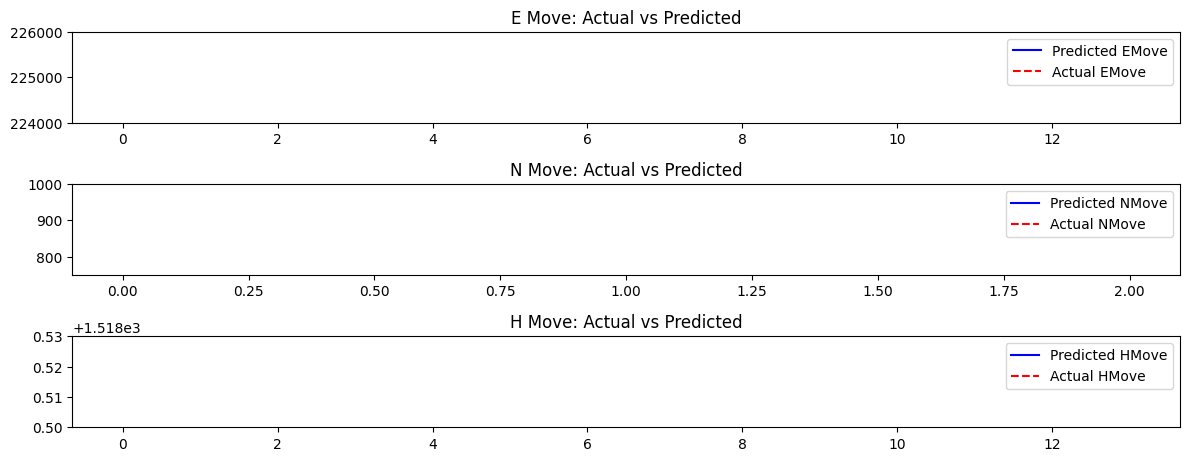

In [50]:
import matplotlib.pyplot as plt


# Plot predictions vs actual values for each movement component
plt.figure(figsize=(12, 6))

plt.suptitle("Actual(blue) vs Predicted(red) Movements Over Time", fontsize=16, fontweight='bold', y=1.02)
n=max_prediction_length
# For EMove (target 0)
actuals_E = actuals[0,:,::n].cpu().numpy()
predicted_E = predictions[0,:,::n].cpu().numpy()

plt.subplot(4, 1, 1)
plt.plot(actuals_E, label="Actual EMove", color='blue')
plt.plot(predicted_E, label="Predicted EMove", color='red', linestyle='dashed')
plt.title("E Move: Actual vs Predicted")
plt.ylim([np.min(actuals_E), np.max(actuals_E)])  # Set same y-axis range

# For NMove (target 1)
actuals_N = actuals[1,:,::n].cpu().numpy()
predicted_N = predictions[1,:,::n].cpu().numpy()
plt.subplot(4, 1, 2)
plt.plot(actuals_N, label="Actual NMove", color='blue')
plt.plot(predicted_N ,label="Predicted NMove", color='red', linestyle='dashed')
plt.title("N Move: Actual vs Predicted")
plt.ylim([np.min(actuals_N), np.max(actuals_N)])  # Set same y-axis range


# For HMove (target 2)
actuals_H = actuals[2,:,::n].cpu().numpy()
predicted_H = predictions[2,:,::n].cpu().numpy()
plt.subplot(4, 1, 3)
plt.plot(actuals_H, label="Actual HMove", color='blue')
plt.plot(predicted_H, label="Predicted HMove", color='red', linestyle='dashed')
plt.title("H Move: Actual vs Predicted")
plt.ylim([np.min(actuals_H), np.max(actuals_H)])  # Set same y-axis range


plt.tight_layout()
plt.show()
